<a href="https://colab.research.google.com/github/bharathi-srini/Bayesian_Inference_Recommender_Systems/blob/master/test_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.metrics import accuracy_score, log_loss, f1_score, brier_score_loss
from sklearn.calibration import calibration_curve
from scipy.interpolate import UnivariateSpline
import scipy.stats as stats
import math

%matplotlib inline

In [2]:
import keras
from keras import backend as K
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Input,Activation, concatenate, Embedding, Reshape
from keras.layers import Flatten, merge, Lambda, Dropout, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.models import model_from_json, load_model 
from keras.regularizers import l1,l2
import tensorflow as tf
import gc

#import talos

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "C:\Users\Pascal\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\Pascal\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\Pascal\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\Pascal\Anaconda3\envs\Deep_Learning\lib\imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\Pascal\Anaconda3\envs\Deep_Learning\lib\imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: Das angegebene Modul wurde nicht gefunden.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/BNN_RecSys/'

df_use = pd.read_csv(root_path+"engineered_data_100.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [58]:
df_use.shape

(2400149, 17)

In [6]:
# Number of product IDs available
N_products = df_use['product_id'].nunique()
N_shoppers = df_use['user_id'].nunique()
print('Unique Products:', N_products)
print('Unique_Users: ', N_shoppers)

Unique Products: 6018
Unique_Users:  100


In [6]:
# load embeddings model
json_file = open(root_path+'NN_embed_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(root_path+"NN_embed_model_weights.h5")
print("Loaded model from disk")

# Exctracted embeddings from pr-trained model
embeddings_prior = loaded_model.layers[2].get_weights()[0]
embeddings_user = loaded_model.layers[3].get_weights()[0]

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


In [0]:
def val2idx(df, cols):
    """
    Helper to index values of embedding columns
    """
    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()

    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x]+1)

    unique_vals = dict()
    for c in cols:
        unique_vals[c] = df[c].nunique()

    return df, unique_vals, val_to_idx

In [0]:
EMBEDDING_COLUMNS = ["user_id", "product_id"]
df_deep, values, mappings = val2idx(df_use, EMBEDDING_COLUMNS)

#df_deep.drop(['product_name','department', 'Unnamed: 0', 'index'], axis=1, inplace=True)

CATEGORICAL_COLUMNS = ["order_dow", "order_hour_of_day","aisle_id","department_id"]
CONTINUOUS_COLUMNS = ["days_since_prior_order","order_number","add_to_cart_order","reordered_total","product_id_orders","user_distinct_products","user_period",\
                     "user_orders","average_cart_position"]

#One-hot encoding categorical columns
df_deep = pd.get_dummies(df_deep, columns=[x for x in CATEGORICAL_COLUMNS])

#Normalising the feature columns
df_deep[CONTINUOUS_COLUMNS] = MinMaxScaler().fit_transform(df_deep[CONTINUOUS_COLUMNS].values)

y = df_deep.reordered.values
df_deep.drop(['reordered'], axis=1, inplace = True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_deep, y, test_size=0.25, random_state=42, stratify=y)

In [137]:
X_test.shape

(600038, 198)

In [14]:
products_in = X_train['product_id']
X_train.drop(['product_id'], axis = 1, inplace=True)

products_test = X_test['product_id']
X_test.drop(['product_id'], axis = 1, inplace=True)

products_all = df_deep.product_id
users_all = df_deep.user_id
df_deep.drop(['user_id', 'product_id'], axis=1, inplace=True)
tensors_all = df_deep

users_in = X_train['user_id']
X_train.drop(['user_id'], axis=1, inplace= True)

users_test = X_test['user_id']
X_test.drop(['user_id'], axis=1, inplace= True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
# Integer IDs representing 1-hot encodings
prior_in = Input(shape=(1,))
shopper_in = Input(shape=(1,))

  # Embeddings
  #prior = Embedding(input_dim=embeddings_prior.shape[0], input_length=1,weights=[embeddings_prior], output_dim=embeddings_prior.shape[1], trainable=False)(prior_in)
  #shopper = Embedding(input_dim=embeddings_user.shape[0], input_length=1,weights=[embeddings_user], output_dim=embeddings_prior.shape[1], trainable=False)(shopper_in)

prior = Embedding(input_dim=1, input_length=1, output_dim=10)(prior_in)
shopper = Embedding(input_dim=1, input_length=1, output_dim=10)(shopper_in)

# Numeric and categorical inputs
input_tensor = Input(shape=X_train.shape[1:])

reshape = Reshape(target_shape=(10,))

combined_input = keras.layers.concatenate([reshape(prior), reshape(shopper), input_tensor])

x = BatchNormalization()(combined_input)

x = Dropout(0.3)(x)
x = Dense(128, activation='softplus')(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)
x = Dense(64, activation='softplus')(x)
x = BatchNormalization()(x)

logits = Dense(1,activation='softplus')(x)
logit_output = Activation('sigmoid', name='softmax_output')(logits)
  
model = Model(inputs=[prior_in, shopper_in, input_tensor], outputs=logit_output)
  
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'] )
  
out = model.fit([products_in, users_in, X_train],y_train, batch_size = 100, epochs = 1,validation_split=0.2 )

Train on 1440088 samples, validate on 360023 samples
Epoch 1/1
1440088/1440088 [==============================] - 211s 146us/step - loss: 0.3630 - acc: 0.8485 - val_loss: 0.3180 - val_acc: 0.8483


In [16]:
#score = model.evaluate([products_test, users_test, X_test], y_test, verbose=1)
#print('Test accuracy:', score[1])

NN_probs = model.predict([products_test, users_test, X_test], verbose=1)

600038/600038 [==============================] - 51s 84us/step
Test accuracy: 0.8484529313143501
600038/600038 [==============================] - 40s 66us/step


In [17]:
logloss_score_NN = log_loss(y_test,NN_probs)
print(logloss_score_NN)
print(f1_score(y_test,np.round(NN_probs), average='weighted'))

0.3169149165821503
0.7788894004272944


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Integer IDs representing 1-hot encodings
prior_in = Input(shape=(1,))
shopper_in = Input(shape=(1,))

# Embeddings
#prior = Embedding(input_dim=embeddings_prior.shape[0], input_length=1,weights=[embeddings_prior], output_dim=embeddings_prior.shape[1], trainable=False)(prior_in)
#shopper = Embedding(input_dim=embeddings_user.shape[0], input_length=1,weights=[embeddings_user], output_dim=embeddings_prior.shape[1], trainable=False)(shopper_in)

prior = Embedding(input_dim=1, input_length=1, output_dim=10)(prior_in)
shopper = Embedding(input_dim=1, input_length=1, output_dim=10)(shopper_in)

# Numeric and categorical inputs
input_tensor = Input(shape=X_train.shape[1:])

reshape = Reshape(target_shape=(10,))

combined_input = keras.layers.concatenate([reshape(prior), reshape(shopper), input_tensor])

x = BatchNormalization()(combined_input)

x = Dropout(0.3)(x, training=True)
x = Dense(128, activation='softplus')(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x, training=True)
x = Dense(64, activation='softplus')(x)
x = BatchNormalization()(x)

logits = Dense(1,activation='softplus')(x)
logit_output = Activation('sigmoid', name='softmax_output')(logits)

model_BNN = Model(inputs=[prior_in, shopper_in, input_tensor], outputs=logit_output)


In [0]:
with open(root_path + 'BNNsummary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model_BNN.summary(print_fn=lambda x: fh.write(x + '\n'))

In [63]:
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model_BNN.compile(optimizer=adam, \
              loss='binary_crossentropy',\
              metrics=['accuracy'] )

history = model_BNN.fit([products_in, users_in, X_train],y_train, batch_size = 100, epochs = 1)

Epoch 1/1
1800111/1800111 [==============================] - 210s 116us/step - loss: 0.3580 - acc: 0.8485


In [0]:
BNN_probs = model_BNN.predict([products_test, users_test, X_test], verbose=1)

600038/600038 [==============================] - 38s 63us/step


In [0]:
def MCdropout(T):
    
    Yt_hat = []
    for _ in range(T):
        Yt_hat += [model_BNN.predict([products_test, users_test, X_test],verbose=0)]
    # 100 arrays with one output of each observation for X_test
    Yt_hat = np.array(Yt_hat)
      
    return Yt_hat
 

In [0]:
    predictive_mean = np.mean(Yt_hat, axis=0)
    epistemic = np.mean(Yt_hat ** 2, axis=0) - np.mean(Yt_hat, axis=0) ** 2
    #epistemic = np.sum(epistemic)
    aleatoric = np.mean(Yt_hat * (1-Yt_hat), axis = 0)
    #aleatoric = np.sum(aleatoric)

In [0]:
start = time.time()
pb5 = MCdropout(5)
print(start - time.time(),'5 done')

start = time.time()
pb10 = MCdropout(10)
print(start - time.time(),'10 done')

start = time.time()
pb20 = MCdropout(20)
print(start - time.time(),'20 done')
start = time.time()

pb50 = MCdropout(50)
print(start - time.time(),'50 done')
start = time.time()

start = time.time()
pb100 = MCdropout(100)
print(start - time.time(),'100 done')

-167.72692942619324 5 done


In [0]:
pb5_50pv = np.percentile(pb5, 50, axis=0)
pb10_50pv = np.percentile(pb10, 50, axis=0)
pb20_50pv = np.percentile(pb20, 50, axis=0)
pb50_50pv = np.percentile(pb50, 50, axis=0)
#pb100_50pv = np.percentile(pb100, 50, axis=0)

print('Accuracy: ',accuracy_score(y_test,np.round(pb5_50pv)),accuracy_score(y_test,np.round(pb10_50pv)),accuracy_score(y_test,np.round(pb20_50pv)),\
     accuracy_score(y_test,np.round(pb50_50pv)) )

Accuracy:  0.8485712571537136 0.8485479252980644 0.8485245934424153 0.8485179271979442


In [0]:
e = []
e.append(accuracy_score(y_test,np.round( BNN_probs  ) ))
e.append(accuracy_score(y_test,np.round( np.mean(pb5, axis=0)  ) ))
e.append(accuracy_score(y_test,np.round( np.mean(pb10, axis=0) ) ))
e.append(accuracy_score(y_test,np.round( np.mean(pb20, axis=0) ) ))
e.append(accuracy_score(y_test,np.round( np.mean(pb50, axis=0) ) ))
#e[4] = 1 - accuracy_score(y_test,np.round(pb100_50pv))

In [0]:
l = []
l.append(log_loss(y_test, BNN_probs  ))
l.append(log_loss(y_test, np.mean(pb5, axis=0)  ) )
l.append(log_loss(y_test, np.mean(pb10, axis=0) ) )
l.append(log_loss(y_test, np.mean(pb20, axis=0) ) )
l.append(log_loss(y_test, np.mean(pb50, axis=0) ) )

pb5_20pv = np.percentile(pb5, 20, axis=0)
pb10_20pv = np.percentile(pb10, 20, axis=0)
pb20_20pv = np.percentile(pb20, 20, axis=0)
pb50_20pv = np.percentile(pb50, 20, axis=0)

pb5_25pv = np.percentile(pb5, 25, axis=0)
pb10_25pv = np.percentile(pb10, 25, axis=0)
pb20_25pv = np.percentile(pb20, 25, axis=0)
pb50_25pv = np.percentile(pb50, 25, axis=0)

l1 = []
l1.append(log_loss(y_test, BNN_probs  ))
l1.append(log_loss(y_test, pb5_50pv) )
l1.append(log_loss(y_test, pb10_50pv ) )
l1.append(log_loss(y_test, pb20_50pv ) )
l1.append(log_loss(y_test, pb50_50pv ) )

l2 = []
l2.append(log_loss(y_test, BNN_probs  ))
l2.append(log_loss(y_test, pb5_20pv) )
l2.append(log_loss(y_test, pb10_20pv ) )
l2.append(log_loss(y_test, pb20_20pv ) )
l2.append(log_loss(y_test, pb50_20pv ) )

l3 = []
l3.append(log_loss(y_test, BNN_probs  ))
l3.append(log_loss(y_test, pb5_25pv) )
l3.append(log_loss(y_test, pb10_25pv ) )
l3.append(log_loss(y_test, pb20_25pv ) )
l3.append(log_loss(y_test, pb50_25pv ) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/

No handles with labels found to put in legend.


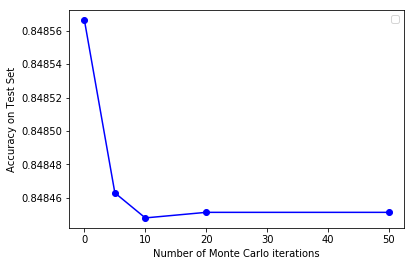

In [0]:
fig, ax = plt.subplots()
xaxis = [0,5,10,20,50]
plt.plot(xaxis, e, color = 'b', marker ='o')

ax.set_xlabel('Number of Monte Carlo iterations')
ax.set_ylabel('Accuracy on Test Set')
plt.legend()

plt.savefig(root_path+"accuracy_drop.png")
plt.show()

In [0]:
pb20 = np.load(root_path+'20samples_preds.csv.npy')

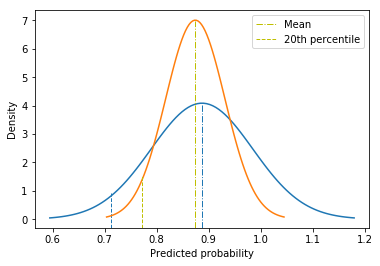

In [45]:

fig, ax = plt.subplots()
mu = np.mean(pb20[:,6025])
variance = np.var(pb20[:,6025])
sigma = math.sqrt(variance)
#x = np.linspace(0, 1.2, 100)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.axvline(x.mean(), linewidth=1,linestyle='-.', ymax=0.57)
plt.axvline(np.percentile(x,20), linestyle='dashed', linewidth=1, ymax=0.16)

mu = np.mean(pb20[:,5640])
variance = np.var(pb20[:,5640])
sigma = math.sqrt(variance)

#5640, 5690

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.axvline(x.mean(), linewidth=1,linestyle='-.', ymax=0.95, label='Mean',color='y')
plt.axvline(np.percentile(x,20), linestyle='--', linewidth=1, ymax=0.24, label='20th percentile', color='y')

ax.set_xlabel('Predicted probability')
ax.set_ylabel('Density')
plt.legend()

plt.savefig(root_path+"pdf_plot.png")

plt.show()

In [46]:
print(np.mean(pb20[:,6025]),np.var(pb20[:,6025]), np.percentile(pb20[:,6025], 20) )
print(np.mean(pb20[:,5640]),np.var(pb20[:,5640]), np.percentile(pb20[:,5640], 20) )
print(np.mean(pb20[:,5650]),np.var(pb20[:,5650]), np.percentile(pb20[:,5650], 20) )
print(np.mean(pb20[:,5660]),np.var(pb20[:,5660]), np.percentile(pb20[:,5660], 20) )

0.8870163 0.009526152 0.8236996173858642
0.8741663 0.0032368437 0.8290057659149169
0.98244685 0.00087530323 0.9809259653091431
0.78083676 0.0043742666 0.7090601086616517


In [47]:
percentile20 = np.percentile(pb20, 20, axis=0)
percentile25 = np.percentile(pb20, 25, axis=0)
percentile40 = np.percentile(pb20, 40, axis=0)
percentile50 = np.percentile(pb20, 50, axis=0)
percentile75 = np.percentile(pb20, 75, axis=0)
percentile80 = np.percentile(pb20, 80, axis=0)
mean_pred = np.mean(pb20, axis=0)


print('Accuracy :', accuracy_score(y_test, np.round(mean_pred)), accuracy_score(y_test, np.round(percentile50)), accuracy_score(y_test, np.round(percentile20)) , accuracy_score(y_test, np.round(percentile80)))
print('Log Loss:', log_loss(y_test, mean_pred), log_loss(y_test, percentile50), log_loss(y_test, percentile20) , log_loss(y_test, percentile80))
print("BNN F1 Score:",f1_score(y_test, np.round(mean_pred), average='weighted'),f1_score(y_test, np.round(percentile50), average='weighted'), f1_score(y_test, np.round(percentile20), average='weighted') , f1_score(y_test, np.round(percentile80), average='weighted') )

Accuracy : 0.8484512647532323 0.8485245934424153 0.8487462460710822 0.8484512647532323
Log Loss: 0.32203130623199927 0.31383570858495163 0.3347190482322151 0.34065173707442814


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


BNN F1 Score: 0.7788894004272944 0.7790989086211965 0.7800918374701405 0.7788894004272944


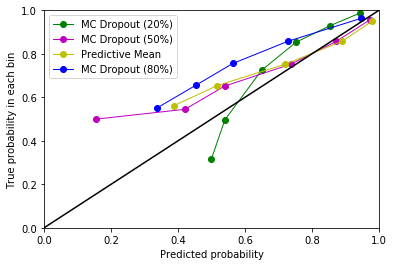

In [0]:
logreg_y_20, logreg_x_20 = calibration_curve(y_test, percentile20, n_bins=10)
logreg_y_25, logreg_x_25 = calibration_curve(y_test, percentile25, n_bins=10)
logreg_y_40, logreg_x_40 = calibration_curve(y_test, percentile40, n_bins=10)
logreg_y_50, logreg_x_50 = calibration_curve(y_test, percentile50, n_bins=10)
logreg_y_75, logreg_x_75 = calibration_curve(y_test, percentile75, n_bins=10)
logreg_y_80, logreg_x_80 = calibration_curve(y_test, percentile80, n_bins=10)
logreg_y_m, logreg_x_m = calibration_curve(y_test, np.mean(pb20, axis=0), n_bins=10)

fig, ax = plt.subplots()
# only these two lines are calibration curves

plt.plot(logreg_x_20,logreg_y_20, marker='o', linewidth=1, label='MC Dropout (20%)',color='g')
plt.plot(logreg_y_50, logreg_x_50, marker='o', linewidth=1, label='MC Dropout (50%)',color='m')
plt.plot(logreg_y_m, logreg_x_m, marker='o', linewidth=1, label='Predictive Mean',color='y')
plt.plot(logreg_y_80, logreg_x_80, marker='o', linewidth=1, label='MC Dropout (80%)',color='b')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()

plt.savefig(root_path+"calibration_plot_20samples.png")
plt.show()

In [0]:
np.save(root_path+'20samples_preds.csv',pb20)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


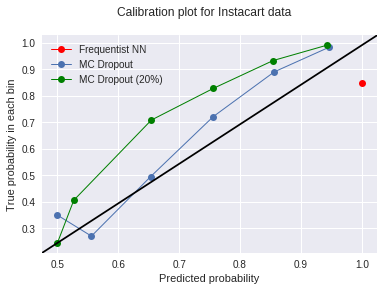

In [0]:
from sklearn.calibration import calibration_curve
logreg_y, logreg_x = calibration_curve(y_test, NN_probs, n_bins=10)

np.save(root_path+'y_NN.csv',logreg_y)
np.save(root_path+'x_NN.csv',logreg_x) 

logreg_y_bnn, logreg_x_bnn = calibration_curve(y_test, predictive_mean_BNN, n_bins=10)
logreg_y_20, logreg_x_20 = calibration_curve(y_test, percentile_probs_BNN, n_bins=10)

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='Frequentist NN', color='red')
plt.plot(logreg_x_bnn,logreg_y_bnn, marker='o', linewidth=1, label='MC Dropout')
plt.plot(logreg_x_20,logreg_y_20, marker='o', linewidth=1, label='MC Dropout (20%)',color='green')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

fig.suptitle('Calibration plot for Instacart data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()

plt.savefig(root_path+"calibration_plot.png")
plt.show()



In [0]:
# Out of distribution samples
#out_user = pd.read_csv(root_path + 'engineered_data_users_out.csv')
#out_prod = pd.read_csv(root_path + 'engineered_data_out_prd.csv')
out_both = pd.read_csv(root_path + 'engineered_data_out_both.csv')

New users : Out of sample 


In [0]:
out_user.shape

(250671, 21)

In [0]:
# Preparing out of sample users data

#EMBEDDING_COLUMNS = ["user_id", "product_id"]
#df_deep, values, mappings = val2idx(df_use, EMBEDDING_COLUMNS)

out_user.drop(['product_name','department', 'Unnamed: 0', 'index'], axis=1, inplace=True)

CATEGORICAL_COLUMNS = ["order_dow", "order_hour_of_day","aisle_id","department_id"]
CONTINUOUS_COLUMNS = ["days_since_prior_order","order_number","add_to_cart_order","reordered_total","product_id_orders","user_distinct_products","user_period",\
                     "user_orders","average_cart_position"]

#One-hot encoding categorical columns
out_user = pd.get_dummies(out_user, columns=[x for x in CATEGORICAL_COLUMNS])

#Normalising the feature columns
out_user[CONTINUOUS_COLUMNS] = MinMaxScaler().fit_transform(out_user[CONTINUOUS_COLUMNS].values)

y = out_user.reordered.values
out_user.drop(['reordered'], axis=1, inplace = True)

products_in = out_user['product_id']
out_user.drop(['product_id'], axis = 1, inplace=True)

users_in = out_user['user_id']
out_user.drop(['user_id'], axis=1, inplace= True)

tensors_all = out_user


In [72]:
for col in X_test.columns:
  if col not in tensors_all.columns:
    tensors_all[col] = 0
    
tensors_all.shape

(250671, 196)

In [73]:
NN_probs_out_user = model.predict([products_in, users_in, tensors_all], verbose=1)

250671/250671 [==============================] - 15s 61us/step


In [0]:
def MCdropout(T):
    
    Yt_hat = []
    for _ in range(T):
        Yt_hat += [model_BNN.predict([products_in, users_in, tensors_all],verbose=0)]
    # 100 arrays with one output of each observation for X_test
    Yt_hat = np.array(Yt_hat)
    
    predictive_mean = np.mean(Yt_hat, axis=0)
    epistemic = np.mean(Yt_hat ** 2, axis=0) - np.mean(Yt_hat, axis=0) ** 2
    #epistemic = np.sum(epistemic)
    aleatoric = np.mean(Yt_hat * (1-Yt_hat), axis = 0)
    
    return Yt_hat, predictive_mean, epistemic, aleatoric

In [0]:
probs_user, predictive_mean_user, model_uncertainty_user, data_uncertainty_user = MCdropout(T=20)

In [78]:
probs_user.shape

(20, 250671, 1)

In [85]:
logloss_score_NN = log_loss(y,NN_probs_out_user)
acc_NN = accuracy_score(y, np.round(NN_probs_out_user))

percentile_probs_user = np.percentile(probs_user, 20, axis=0)

logloss_score1 = log_loss(y,percentile_probs_user)
acc1 = accuracy_score(y, np.round(percentile_probs_user))

print('With NN_preds: ',logloss_score_NN, acc_NN)
print('With percentile_preds: ',logloss_score1, acc1)

# Testing dropout model accuracy
print('With BNN mean:',log_loss(y, predictive_mean_user), accuracy_score(y, np.round(predictive_mean_user)) )
print('Epistemic Uncertainty : ', np.mean(model_uncertainty_user))
print('Aleatoric Uncertainty : ', np.mean(data_uncertainty_user))


print("BNN F1 Score:",f1_score(y, np.round(percentile_probs_user), average='weighted') )
print("NN F1 Score:",f1_score(y,np.round(NN_probs_out_user) , average='weighted') )

from sklearn.metrics import brier_score_loss
print("BNN Brier: ", brier_score_loss(y, predictive_mean_user))
print("NN Brier: ", brier_score_loss(y, NN_probs_out_user))

With NN_preds:  0.5501349128911854 0.7340059280890091
With percentile_preds:  0.6226257696591567 0.7333476947871912
With BNN mean: 0.5454411827754908 0.7339740137471028
Epistemic Uncertainty :  0.017196398
Aleatoric Uncertainty :  0.19020279
BNN F1 Score: 0.6359510160411228
NN F1 Score: 0.6214471893306
BNN Brier:  0.18220884168668233
NN Brier:  0.1841366318516883


In [0]:
New products - of of sample

In [86]:
# Preparing out of sample products data
#EMBEDDING_COLUMNS = ["user_id", "product_id"]
#df_deep, values, mappings = val2idx(df_use, EMBEDDING_COLUMNS)

out_prod.drop(['product_name','department', 'Unnamed: 0', 'index'], axis=1, inplace=True)

CATEGORICAL_COLUMNS = ["order_dow", "order_hour_of_day","aisle_id","department_id"]
CONTINUOUS_COLUMNS = ["days_since_prior_order","order_number","add_to_cart_order","reordered_total","product_id_orders","user_distinct_products","user_period",\
                     "user_orders","average_cart_position"]

#One-hot encoding categorical columns
out_prod = pd.get_dummies(out_prod, columns=[x for x in CATEGORICAL_COLUMNS])

#Normalising the feature columns
out_prod[CONTINUOUS_COLUMNS] = MinMaxScaler().fit_transform(out_prod[CONTINUOUS_COLUMNS].values)

y = out_prod.reordered.values
out_prod.drop(['reordered'], axis=1, inplace = True)

products_in = out_prod['product_id']
out_prod.drop(['product_id'], axis = 1, inplace=True)

users_in = out_prod['user_id']
out_prod.drop(['user_id'], axis=1, inplace= True)

tensors_all = out_prod

for col in X_test.columns:
  if col not in tensors_all.columns:
    tensors_all[col] = 0
    
tensors_all.shape

(1370958, 196)

In [95]:
NN_probs = model.predict([products_in, users_in, tensors_all], verbose=1)

1347756/1347756 [==============================] - 83s 61us/step


In [0]:
def MCdropout(T):
    
    Yt_hat = []
    for _ in range(T):
        Yt_hat += [model_BNN.predict([products_in, users_in, tensors_all],verbose=0)]
    # 100 arrays with one output of each observation for X_test
    Yt_hat = np.array(Yt_hat)
    
    predictive_mean = np.mean(Yt_hat, axis=0)
    epistemic = np.mean(Yt_hat ** 2, axis=0) - np.mean(Yt_hat, axis=0) ** 2
    #epistemic = np.sum(epistemic)
    aleatoric = np.mean(Yt_hat * (1-Yt_hat), axis = 0)
    #aleatoric = np.sum(aleatoric)
    
    return Yt_hat, predictive_mean, epistemic, aleatoric
  
probs, predictive_mean, model_uncertainty, data_uncertainty = MCdropout(T=20)

In [98]:
logloss_score_NN = log_loss(y,NN_probs)
acc_NN = accuracy_score(y, np.round(NN_probs))

percentile_probs = np.percentile(probs, 20, axis=0)

logloss_score1 = log_loss(y,percentile_probs)
acc1 = accuracy_score(y, np.round(percentile_probs))

print('With NN_preds: ',logloss_score_NN, acc_NN)
print('With percentile_preds: ',logloss_score1, acc1)

# Testing dropout model accuracy
print('BNN Mean Accuracy :', accuracy_score(y, np.round(predictive_mean)))
print('BNN Mean Log Loss :', log_loss(y, predictive_mean))
print('Epistemic Uncertainty : ', np.mean(model_uncertainty))
print('Aleatoric Uncertainty : ', np.mean(data_uncertainty))


print("BNN F1 Score:",f1_score(y, np.round(percentile_probs), average='weighted') )
print("NN F1 Score:",f1_score(y,np.round(NN_probs) , average='weighted') )

print("BNN Brier: ", brier_score_loss(y, percentile_probs))
print("NN Brier: ", brier_score_loss(y, NN_probs))

With NN_preds:  0.7749222440309856 0.4762813150154776
With percentile_preds:  0.6874046358884232 0.522465490786166
BNN Mean Accuracy : 0.475882874941755
BNN Mean Log Loss : 0.6958519914493957
Epistemic Uncertainty :  0.020104082
Aleatoric Uncertainty :  0.20755515
BNN F1 Score: 0.42256281038435145
NN F1 Score: 0.3077684791375566
BNN Brier:  0.24706477501365853
NN Brier:  0.2718917325485952


New users + New products


In [0]:
# Preparing out of sample users data
#EMBEDDING_COLUMNS = ["user_id", "product_id"]
#df_deep, values, mappings = val2idx(df_use, EMBEDDING_COLUMNS)

#out_both.drop(['product_name','department', 'Unnamed: 0', 'index'], axis=1, inplace=True)

CATEGORICAL_COLUMNS = ["order_dow", "order_hour_of_day","aisle_id","department_id"]
CONTINUOUS_COLUMNS = ["days_since_prior_order","order_number","add_to_cart_order","reordered_total","product_id_orders","user_distinct_products","user_period",\
                     "user_orders","average_cart_position"]

#One-hot encoding categorical columns
out_both = pd.get_dummies(out_both, columns=[x for x in CATEGORICAL_COLUMNS])

#Normalising the feature columns
out_both[CONTINUOUS_COLUMNS] = MinMaxScaler().fit_transform(out_both[CONTINUOUS_COLUMNS].values)

y = out_both.reordered.values
out_both.drop(['reordered'], axis=1, inplace = True)

products_in = out_both['product_id']
out_both.drop(['product_id'], axis = 1, inplace=True)

users_in = out_both['user_id']
out_both.drop(['user_id'], axis=1, inplace= True)

tensors_all = out_both

In [141]:
print(products_in.shape, users_in.shape, tensors_all.shape)

(1347756,) (1347756,) (1347756, 146)


In [0]:
for col in X_test.columns:
  if col not in tensors_all.columns:
    tensors_all[col] = 0

In [0]:
tensors_all.drop(['user_id', 'product_id'], axis=1, inplace=True)

In [144]:
tensors_all.shape

(1347756, 200)

In [0]:
NN_probs = model.predict([products_in, users_in, tensors_all], verbose=1)

In [0]:
def MCdropout(T):
    
    Yt_hat = []
    for _ in range(T):
        Yt_hat += [model_BNN.predict([products_in, users_in, tensors_all],verbose=0)]
    # 100 arrays with one output of each observation for X_test
    Yt_hat = np.array(Yt_hat)
    
    predictive_mean = np.mean(Yt_hat, axis=0)
    epistemic = np.mean(Yt_hat ** 2, axis=0) - np.mean(Yt_hat, axis=0) ** 2
    #epistemic = np.sum(epistemic)
    aleatoric = np.mean(Yt_hat * (1-Yt_hat), axis = 0)
    #aleatoric = np.sum(aleatoric)
    
    return Yt_hat, predictive_mean, epistemic, aleatoric
  
probs, predictive_mean, model_uncertainty, data_uncertainty = MCdropout(T=20)

In [105]:
logloss_score_NN = log_loss(y,NN_probs)
acc_NN = accuracy_score(y, np.round(NN_probs))

percentile_probs = np.percentile(probs, 20, axis=0)

logloss_score1 = log_loss(y,percentile_probs)
acc1 = accuracy_score(y, np.round(percentile_probs))

print('With NN_preds: ',logloss_score_NN, acc_NN)
print('With percentile_preds: ',logloss_score1, acc1)

# Testing dropout model accuracy
print('Accuracy BNN mean :', accuracy_score(y, np.round(predictive_mean)))
print('Log Loss BNN mean :', log_loss(y, predictive_mean))
print('Epistemic Uncertainty : ', np.mean(model_uncertainty))
print('Aleatoric Uncertainty : ', np.mean(data_uncertainty))

from sklearn.metrics import f1_score

print("BNN F1 Score:",f1_score(y, np.round(percentile_probs), average='weighted') )
print("NN F1 Score:",f1_score(y,np.round(NN_probs) , average='weighted') )

print("BNN Brier: ", brier_score_loss(y, percentile_probs))
print("NN Brier: ", brier_score_loss(y, NN_probs))

With NN_preds:  0.7749222440309856 0.4762813150154776
With percentile_preds:  0.6873614547589103 0.5225901424293418
Accuracy BNN mean : 0.4758880687602207
Log Loss BNN mean : 0.6957250232367913
Epistemic Uncertainty :  0.020099426
Aleatoric Uncertainty :  0.20757474
BNN F1 Score: 0.42277701514824684
NN F1 Score: 0.3077684791375566
BNN Brier:  0.24704148414959048
NN Brier:  0.2718917325485952


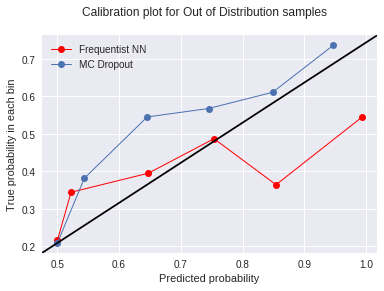

In [0]:
logreg_y_bnn, logreg_x_bnn = calibration_curve(y, predictive_mean, n_bins=10)
logreg_y, logreg_x = calibration_curve(y, NN_probs, n_bins=10)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='Frequentist NN', color='red')
plt.plot(logreg_x_bnn,logreg_y_bnn, marker='o', linewidth=1, label='MC Dropout')
#plt.plot(logreg_x_20,logreg_y_20, marker='o', linewidth=1, label='MC Dropout (20%)',color='green')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

fig.suptitle('Calibration plot for Out of Distribution samples')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()

plt.savefig(root_path+"calibration_plot_out.png")
plt.show()

**Ranking Products based on prediction probabilties**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_use, y, test_size=0.25, random_state=42, stratify=y)

In [0]:
percentile_probs = np.percentile(pb20, 20, axis=0)

In [78]:
#df_tr, df_test, y_tr, y_te = train_test_split(df_use, df_use.reordered, test_size=0.20, random_state=42, stratify=y)
print(y_test.shape, NN_probs.shape, pb20.shape, percentile_probs.shape)

(600038,) (600038, 1) (20, 600038, 1) (600038, 1)


In [180]:
X_test['NN_probs'] = NN_probs
#df_test['BNN_mean'] = predictive_mean_BNN
X_test['BNN_20p'] = percentile_probs
X_test['lgb_probs'] = light_gbm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [149]:
X_test.reordered = y_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [151]:
X_test.shape

(600038, 201)

In [0]:
light_gbm = np.load(root_path +'lightGBM_pred.npy')

In [177]:
#X_test = X_test[X_test.reordered ==1]
print(X_test.shape, X_test.user_id.nunique(), X_test.product_id.nunique())

(600038, 201) 100 3902


In [0]:
#X_test.to_csv(root_path+'results_new.csv')

In [181]:
df_test = X_test
df_test = df_test.drop_duplicates(subset=['order_id','user_id','product_id'])
df_test['NN_ranks'] = pd.DataFrame(df_test.groupby('order_id')['NN_probs'].rank(ascending=False))
df_test['BNN_ranks20'] = pd.DataFrame(df_test.groupby('order_id')['BNN_20p'].rank(ascending=False))
df_test['lgb_ranks'] = pd.DataFrame(df_test.groupby('order_id')['lgb_probs'].rank(ascending=False))
#df_test['BNN_ranks_mean'] = pd.DataFrame(df_test.groupby('order_id')['BNN_mean'].rank(ascending=False))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [182]:
df_test.head()

,order_id,product_id,add_to_cart_order,user_id,order_number,days_since_prior_order,average_cart_position,user_orders,user_period,user_distinct_products,...,department_id_19,department_id_20,department_id_21,NN_probs,BNN_20p,lgb,lgb_probs,NN_ranks,BNN_ranks20,lgb_ranks
2339401,3176626,407,0.000000,100,0.181818,0.166667,0.058197,1.000000,0.215989,0.597333,...,0,0,0,0.950271,0.940211,0.950826,0.950826,1.0,1.0,11.0
230893,1076593,26,0.074627,7,0.383838,0.200000,0.132638,1.000000,0.503279,0.536000,...,0,0,0,0.989375,0.973157,0.975385,0.975385,2.0,2.0,7.0
149784,2115926,121,0.044776,6,0.414141,0.400000,0.122951,0.447917,0.456274,0.485333,...,0,0,0,0.969021,0.937269,0.976975,0.976975,5.0,3.0,10.0
1754428,3018235,129,0.044776,74,0.171717,0.233333,0.049180,0.364583,0.352638,0.594667,...,0,0,0,0.848032,0.803881,0.796950,0.796950,1.0,1.0,10.0
764667,1359768,1000,0.000000,19,0.010101,0.266667,0.175410,0.395833,0.613521,0.600000,...,0,0,0,0.694737,0.550198,0.830898,0.830898,7.0,8.0,17.0


In [0]:
Top10_df = df_test[df_test.BNN_ranks20 < 11]

In [0]:
Top10_df = Top10_df.sort_values(by=['user_id','order_number','BNN_ranks20'])

In [0]:
ordered_list = pd.DataFrame(Top10_df.groupby('order_id').apply(lambda order: order['product_id'].tolist()))
ordered_list.reset_index(inplace=True)
ordered_list.columns = ['order_id','ordered']

In [0]:
recommended_list_BNN20 = pd.DataFrame(Top10_df.groupby('order_id').apply(lambda order: order.product_id[order['BNN_ranks20']<6].tolist()))
recommended_list_BNN20.reset_index(inplace=True)
recommended_list_BNN20.columns = ['order_id','BNN_recommend20']

#recommended_list_BNN_mean = pd.DataFrame(Top10_df.groupby('order_id').apply(lambda order: order.product_id[order['BNN_ranks_mean']<6].tolist()))
#recommended_list_BNN_mean.reset_index(inplace=True)
#recommended_list_BNN_mean.columns = ['order_id','BNN_recommend_mean']

In [0]:
Top10_df = Top10_df.sort_values(by=['user_id','order_number','NN_ranks'])

recommended_list_NN = pd.DataFrame(Top10_df.groupby('order_id').apply(lambda order: order.product_id[order['NN_ranks']<6].tolist()))
recommended_list_NN.reset_index(inplace=True)
recommended_list_NN.columns = ['order_id','NN_recommend']

In [0]:
Top10_df = Top10_df.sort_values(by=['user_id','order_number','lgb_ranks'])

recommended_list_lgb = pd.DataFrame(Top10_df.groupby('order_id').apply(lambda order: order.product_id[order['lgb_ranks']<6].tolist()))
recommended_list_lgb.reset_index(inplace=True)
recommended_list_lgb.columns = ['order_id','lgb_recommend']

In [191]:
merged = pd.merge(ordered_list, Top10_df[['order_id','user_id','order_number']], on='order_id',how='left')
merged.drop_duplicates(subset=['order_id'],inplace=True)
merged.shape

(3388, 4)

In [0]:
merged_rank = pd.merge(merged, recommended_list_NN, on='order_id',how='left')
merged_ranks = pd.merge(merged_rank, recommended_list_BNN20, on='order_id', how='left')
merged_ranks = pd.merge(merged_rank, recommended_list_lgb, on='order_id', how='left')
#merged_ranks = pd.merge(merged_ranks, recommended_list_BNN_mean, on='order_id', how='left')

In [0]:
merged_ranks.sort_values(by=['user_id','order_number'], inplace=True)
merged_ranks.reset_index(inplace=True)

In [0]:
merged_ranks.next_order = 0

In [0]:
for index, row in merged_ranks.iterrows():
  if index == merged_ranks.shape[0] - 1:
    break
  if merged_ranks.loc[index].user_id == merged_ranks.loc[index+1].user_id :
    merged_ranks.loc[index].next_order = merged_ranks.loc[index+1].ordered
  


In [194]:
merged_ranks.head()

,index,order_id,ordered,user_id,order_number,NN_recommend,lgb_recommend
0,1129,1116941,"[27, 43, 5, 28, 1, 55, 22, 18]",1,0.000000,"[27, 43, 28, 1, 55]","[22, 18, 1, 55, 28]"
1,1957,1955023,"[6, 24, 48, 13]",1,0.010101,"[6, 24, 48, 13]","[24, 6, 48, 13]"
2,2059,2055204,[17],1,0.020202,[17],[17]
3,2353,2369882,"[29, 36, 17, 19, 12, 2, 6, 25, 39, 1]",1,0.030303,"[6, 1, 17, 36]","[36, 2, 39, 25]"
4,96,98059,"[10, 6]",1,0.040404,"[6, 10]","[6, 10]"


In [0]:
def filter(x, y):
  count = 0
  for num in y:
    if num in x:
      count += 1
  return count

In [0]:
nn_hits = 0
#bnn20_hits = 0
lgb_hits = 0
#bnn_mean_hits = 0
T = merged_ranks.shape[0]*5
for index,row in merged_ranks.iterrows():
  #T += len(row.ordered)
  if merged_ranks.user_id[index] == merged_ranks.user_id[index+1]:
    #bnn20_hits += len(set(row.BNN_recommend20) & set(merged_ranks.ordered[index+1]))
    #bnn_mean_hits += len(set(row.BNN_recommend_mean) & set(merged_ranks.ordered[index+1]))
    nn_hits += len(set(row.NN_recommend) & set(merged_ranks.ordered[index+1]))
    lgb_hits += len(set(row.lgb_recommend) & set(merged_ranks.ordered[index+1]))
  
  #nn_hits += filter(row.NN_recommend,merged_ranks.ordered[index+1] )
  if(index == merged_rank.shape[0]-2):
    break

In [196]:
print('Recall for NN:', float(nn_hits/T))
print('Recall for BNN by 20%:', float(bnn20_hits/T))
print('Recall for LGB:', float(lgb_hits/T))
#print('Recall for BNN by mean:', float(bnn_mean_hits/T))
print('Precision for NN:', float(nn_hits/(5*T)))
print('Precision for BNN by 20%:', float(bnn20_hits/(5*T)))
print('Precision for LGB:', float(lgb_hits/(5*T)))
#print('Precision for BNN by mean:', float(bnn_mean_hits/(5*T)))

Recall for NN: 0.27609208972845334
Recall for BNN by 20%: 0.2915584415584416
Recall for LGB: 0.19929161747343566
Precision for NN: 0.05521841794569067
Precision for BNN by 20%: 0.058311688311688314
Precision for LGB: 0.03985832349468713


In [0]:
# Approximate Hits
import keras.backend as K
def pairwise_cosine_sim(A, B):
    """
    A [n x d] tensor of n rows with d dimensions
    B [n x d] tensor of n rows with d dimensions

    returns:
    D [n x m] tensor of cosine similarity scores between each point i<n, j<m
    """

    #A, B = A_B
    A_mag = l2_norm(A, axis=1)
    B_mag = l2_norm(B, axis=1)
    num = K.batch_dot(A_tensor, K.permute_dimensions(B_tensor, (1,0)))
    den = (A_mag * K.permute_dimensions(B_mag, (1,0)))
    dist_mat =  num / den

    return dist_mat

In [0]:
#B_tensor = K.constant(B)
A_input = keras.Input(tensor=A_tensor)
B_input = keras.Input(tensor=B_tensor)
dist_output = keras.layers.Lambda(pairwise_cosine_sim)([A_input, B_input])
dist_model = keras.Model(inputs=[A_input, B_input], outputs=dist_output)
dist_model.compile("sgd", "mse")